<a href="https://colab.research.google.com/github/marissa-graham/deep_learning/blob/master/Lab_3_(First_DNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and imports

In [0]:
!pip3 install torch
!pip3 install torchvision
!pip install tqdm

    100% |████████████████████████████████| 591.8MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61a86000 @  0x7ffae9d652a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 4.2MB/s 
    100% |████████████████████████████████| 2.0MB 14.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm

assert torch.cuda.is_available()

from torch.nn.parameter import Parameter
import pdb

# Classes (Parts 0-2)

In [0]:
class FashionMNISTProcessedDataset(Dataset):
    
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(root, train=train, 
                    transform=transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), 
                    download=True)
    
    def __getitem__(self, i):
        x, y = self.data[i]
        return x, y
  
    def __len__(self):
        return len(self.data)

class Conv2d(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 dilation=1, groups=1, bias=True, initialization='uniform'):
        """
        Weight is shape (out, in, k, k) i.e.
            (out_channels, in_channels, rows in kernel, cols in kernel)
        """
        
        # Turn all the parameters into selfs and such
        
        self.__dict__.update(locals())
        super(Conv2d, self).__init__()
        
        # Set up our blank weight and bias parameters
        
        k = self.kernel_size
        weight_shape = (out_channels, in_channels, *k)
        self.weight = Parameter(torch.Tensor(*weight_shape))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        
        # Initialize weight and bias
        
        if bias:
            self.bias.data.uniform_(0,0)
        
        if initialization == 'uniform':
            self.weight.data.uniform_(-1,1)
        
        elif initialization == 'xavier':
            
            scale = 1.0 / np.sqrt(self.in_channels)
            w = scale * np.random.randn(*self.weight.size()).astype(np.float32)
            self.weight.data = torch.from_numpy(w)
        
        elif initialization == 'orthogonal':
            
            num_columns = self.in_channels * k[0] * k[1]
            R = np.random.rand(out_channels, num_columns).astype(np.float32)
            U, s, Vt = la.svd(R, full_matrices=True)
            W = np.dot(la.diagsvd(s,self.out_channels,num_columns),Vt)
            
            if W.shape == R.shape:
                self.weight.data = torch.from_numpy(W.reshape(weight_shape))
            else:
                print("THE THING DIDN'T MAKE THE RIGHT SHAPE")

        else:
            raise ValueError('Invalid initialization parameter.')
        
        
    def forward(self, x):
        """Run the convolution on x given our weights."""
        
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, 
                        self.dilation, self.groups)
    
    def extra_repr(self):
        """Add extra stuff to the way it prints itself (optional)"""
        pass
        
class ConvNetwork(nn.Module):
    
    def __init__(self, dataset):
        
        super(ConvNetwork, self).__init__()
        
        x, y = dataset[0]
        
        # Channels, height, and width (dimensions of the input dataset)
        c, h, w = x.size()
        
        # We want to return a prob. dist. across possible classifications
        output = 10 
        
        self.net = nn.Sequential(
            Conv2d(c, 10, (3,3), padding=(1,1), initialization='xavier'), 
            nn.ReLU(),
            Conv2d(10, 24, (5,5), padding=(2,2), initialization='xavier'), #6k
            nn.ReLU(),
            Conv2d(24, 32, (3,3), padding=(1,1), initialization='xavier'), #7k
            nn.ReLU(),
            Conv2d(32, 64, (5,5), padding=(2,2), initialization='xavier'), #50k
            nn.ReLU(),
            Conv2d(64, 64, (3,3), padding=(1,1), initialization='xavier'), #37k
            nn.ReLU(),
            Conv2d(64, 32, (5,5), padding=(2,2), initialization='orthogonal'), #50k
            nn.ReLU(),
            Conv2d(32, 32, (3,3), padding=(1,1), initialization='xavier'), #7k
            nn.ReLU(),
            Conv2d(32, 10, (5,5), padding=(2,2), initialization='xavier'), #25k
            nn.ReLU(),
            Conv2d(10, output, (28,28), padding=(0,0), initialization='xavier') #250k
        ) 
        """
        Conv2d(64, 64, (5,5), padding=(2,2), initialization='xavier'), #102k
        nn.ReLU(),
        Conv2d(64, 64, (3,3), padding=(1,1), initialization='xavier'), #37k
        nn.ReLU(),
        Conv2d(64, 128, (5,5), padding=(2,2), initialization='xavier'), #205k
        nn.ReLU(),
        Conv2d(128, 64, (3,3), padding=(1,1), initialization='xavier'), #74k
        nn.ReLU(),
        Conv2d(64, 64, (5,5), padding=(2,2), initialization='xavier'), #102k
        nn.ReLU(),
        Conv2d(64, 64, (3,3), padding=(1,1), initialization='xavier'), #37k
        nn.ReLU(),
        """

    def forward(self, x):
        
        # Output is (n, 10, 1, 1), so we squeeze out the extra dimensions
        return self.net(x).squeeze(2).squeeze(2) 
    
class CrossEntropyLoss(nn.Module):
    """
    Calculate the cross-entropy loss.
    
    Accepts input array, vector of correct values, returns scalar of loss.
    """
    def __init__(self, weight=None, size_average=None, ignore_index=-100,
                reduce=None, reduction='elementwise_mean'):
        self.__dict__.update(locals())
        super(CrossEntropyLoss, self).__init__()
        
    def forward(self, input, target):
        """
        Each row in input represents a test data point.
        """
        
        # Subtract row maximums
        shifted = input - torch.max(input,dim=1)[0].unsqueeze(1)
        
        
        # Select the value at each true result
        scores = torch.gather(shifted, 1, target.unsqueeze(1))
        
        # log sum exp
        myexp = torch.exp(shifted)
        logsumexp = torch.log(torch.sum(myexp/torch.sum(myexp),dim=1))
        
        # Subtract out score values and return the average
        return torch.mean(logsumexp - scores)

# Set up and train models (Part 3)

In [0]:
train_data = FashionMNISTProcessedDataset('/tmp/fashionmnist')
val_data = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

print(len(train_data))
print(len(val_data))

60000
10000


Epoch 1: loss 47533.0977, accuracy 0.119:   0%|          | 0/1429 [00:00<?, ?it/s]


Total number of parameters: 248160


Epoch 1: loss 809.7158, accuracy 0.286: 100%|██████████| 1429/1429 [02:57<00:00, 13.41it/s]
/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Last few losses: [ 708.6255 1077.2308  663.0034  930.0668  809.7158]
Last few accuracies: [[1.001e+03 4.359e-01]
 [1.101e+03 4.373e-01]
 [1.201e+03 4.473e-01]
 [1.301e+03 4.558e-01]
 [1.401e+03 4.669e-01]]


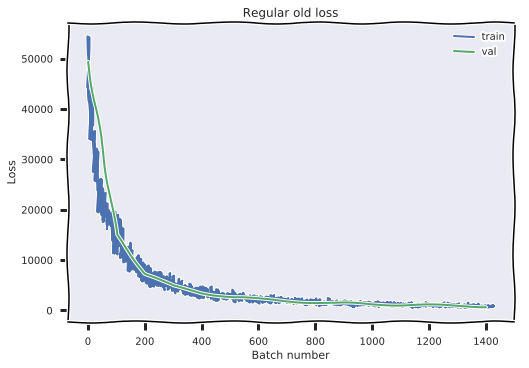

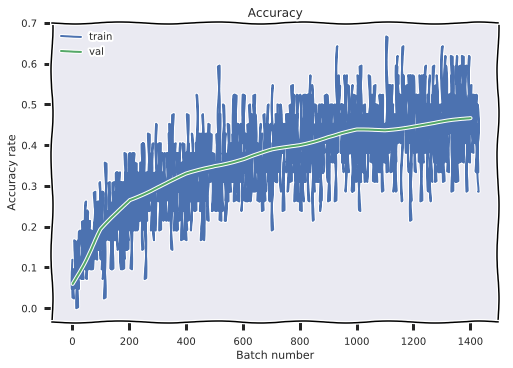

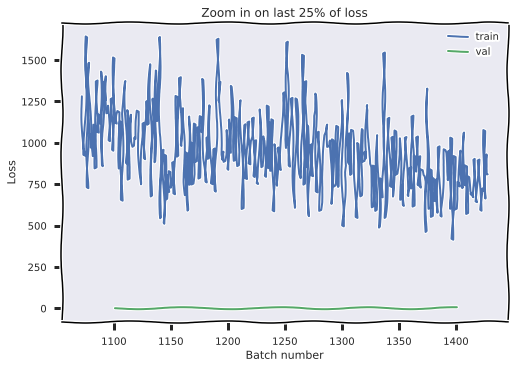

In [0]:
train_data = FashionMNISTProcessedDataset('/tmp/fashionmnist')
val_data = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

model = ConvNetwork(train_data).cuda() 

# Print number of parameters (see if you can get one with close to a million)
#print("Number of parameters in each Parameter object:")
#for p in model.parameters():
#    print(np.prod(np.array(list(p.size()))))
n_params = sum([np.prod(np.array(list(p.size()))) for p in model.parameters()])
print("\nTotal number of parameters:", n_params)

objective = CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=3e-5)

train_loader = DataLoader(train_data, batch_size=42, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=42, pin_memory=True)

losses, validations, train_accuracies, val_accuracies = [], [], [], []
num_epochs = 1

for epoch in range(1,num_epochs+1):

    loop = tqdm(total=len(train_loader), position=0, leave=True)

    for batch, (x, y_truth) in enumerate(train_loader):


        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
        optimizer.zero_grad()
        y_hat = model(x)

        loss = objective(y_hat, y_truth)
        num_correct = torch.sum(y_truth == torch.argmax(y_hat,dim=1))
        a = float(num_correct) / float(train_loader.batch_size)
        train_accuracies.append(a)

        loss.backward()
        losses.append(loss.item())

        s = "Epoch {}: loss {:.4f}, accuracy {:.3f}".format(epoch, loss, a)
        loop.set_description(s)
        loop.update(1)

        optimizer.step()

        if batch % 100 == 0:
            val = np.mean([objective(model(x.cuda()), y.cuda()).item()
                           for x, y in val_loader])
            validations.append((len(losses), val))

            a = np.mean([
                torch.sum(torch.argmax(model(x.cuda()),dim=1) == y.cuda())
                for x, y in val_loader])
            val_accuracies.append((len(losses), a/42.0))

    loop.close()

# Print last few losses
print("Last few losses:", np.round(losses[-5:],4))
print("Last few accuracies:", np.round(val_accuracies[-5:],4))

# Plot accuracy of training and validation set over time
a, b = zip(*validations)
plt.plot(losses, label='train')
plt.plot(a, b, label='val')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title("Regular old loss")
plt.legend()
plt.show()

a, b = zip(*val_accuracies)
plt.plot(train_accuracies, label='train')
plt.plot(a, b, label='val')
plt.xlabel('Batch number')
plt.ylabel('Accuracy rate')
plt.title("Accuracy")
plt.legend()
plt.show()


q = 0.25
n = len(losses)
plt.plot(np.arange(n-int(q*n),n),losses[-int(q*n):], label='train')
plt.plot(a[-int(q*len(a))-1:],b[-int(q*len(b))-1:], label='val')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title("Zoom in on last 25% of loss")
plt.legend()
plt.show()

# Quiz questions (Part 4)

In [0]:
def test_settings(c2, h2, w2, kernel_size=(3,3), c1=3, h1=10, w1=10, 
                  verbose=True):
    
    correct_shape = [1, c2, h2, w2]
    
    # The output channel setting is obvious
    out_channels = c2
    
    # The padding is half the increase in size for each dimension, plus half
    # the size of the kernel for each dimension (rounded down for odd numbers)
    k1, k2 = kernel_size
    p1 = int((h2 - h1)/2 + k1//2)
    p2 = int((w2 - w1)/2 + k2//2)
    
    
    c = nn.Conv2d(c1, out_channels, kernel_size=kernel_size, padding=(p1,p2))
    shape = list(c(torch.zeros(1, c1, h1, w1)).size())
    
    if verbose:
        #print('Padding should be', (p1,p2))
        #print("Out shape is "+str(shape)+"; should be [1, "+str(c2)+", "+
        #      str(h2)+", "+str(w2)+"]")
        if shape == correct_shape:
            print('\tPadding should be', (p1,p2), "SUCCESS")
        else:
            print('\tPadding should be', (p1,p2), "FAILURE")
    
    return (shape == correct_shape)
    
print("3x3 kernels:\n")
for shape in [(10,8,8), (22,10,10), (65,12,12), (7,20,20)]:
    test_settings(*shape, kernel_size=(3,3))

print("\n5x5 kernels:\n")
for shape in [(10,8,8), (100,10,10), (23,12,12), (5,24,24)]:
    test_settings(*shape, kernel_size=(5,5))
    
print("\n5x3 kernels:\n")
for shape in [(10,8,8), (100,10,10), (23,12,12), (5,24,24)]:
    test_settings(*shape, kernel_size=(5,3))

3x3 kernels:

	Padding should be (0, 0) SUCCESS
	Padding should be (1, 1) SUCCESS
	Padding should be (2, 2) SUCCESS
	Padding should be (6, 6) SUCCESS

5x5 kernels:

	Padding should be (1, 1) SUCCESS
	Padding should be (2, 2) SUCCESS
	Padding should be (3, 3) SUCCESS
	Padding should be (9, 9) SUCCESS

5x3 kernels:

	Padding should be (1, 0) SUCCESS
	Padding should be (2, 1) SUCCESS
	Padding should be (3, 2) SUCCESS
	Padding should be (9, 8) SUCCESS


### Settings to go from output shape (c1,h1,w1) to output shape (c2,h2,w2)

#### Kernel size 3x3
| (c1,h1,w1) | (c2,h2,w2) | `out_channels` | `kernel_size` | `padding` |
| --------------- | --- | ---- | --- | --- |
|(3,10,10)|(10,8,8)| 10 | (3,3) | (0,0) |
|(3,10,10)|(22,10,10)| 22 | (3,3) | (1,1) ||
|(3,10,10)|(65,12,12)| 65 | (3,3) | (2,2) |
|(3,10,10)|(7,20,20)| 7 | (3,3) | (6,6) |

#### Kernel size 5x5
| (c1,h1,w1) | (c2,h2,w2) | `out_channels` | `kernel_size` | `padding` |
| --- | --- | --- | --- | --- |
|(3,10,10)|(10,8,8)| 10 | (5,5) | (1,1) |
|(3,10,10)|(100,10,10)| 100 | (5,5) | (2,2) |
|(3,10,10)|(23,12,12)| 23 | (5,5) | (3,3) |
|(3,10,10)|(5,24,24)| 5 | (5,5) | (9,9) |

#### Kernel size 5x3
| (c1,h1,w1) | (c2,h2,w2) | `out_channels` | `kernel_size` | `padding` |
| --- | --- | --- | --- | --- |
|(3,10,10)|(10,8,8)| 10 | (5,3) | (1,0) |
|(3,10,10)|(100,10,10)| 100 | (5,3) | (2,1) |
|(3,10,10)|(23,12,12)| 23 | (5,3) | (3,2) |
|(3,10,10)|(5,24,24)| 5 | (5,3) | (9,8) |

### What kernel requires the smallest padding size for following mappings?


| (c1,h1,w1) | (c2,h2,w2) |`kernel_size`|`padding` |
| --- | --- | --- | 
|(3,10,10)|(10,9,7)| (2,4) | (0,0) |
|(3,10,10)|(22,10,10)| (1,1) | (0,0) |

Choosing kernel sizes:

* The minimum kernel size in each dimension to get zero padding is 1 + max{h1-h2, 0}, I'm pretty sure

In [0]:
# Quickly get lots of nice data on what works and doesn't 
for k1 in range(1,10):
    for k2 in range(2,10):
        #if test_settings(10, 9, 7, kernel_size=(k1,k2), verbose=False):
        #    print("\nKernel size", k1, "x", k2, ":\n")
        print(k1, "x", k2, ":") 
        test_settings(10, 9, 7, kernel_size=(k1,k2))

1 x 2 :
	Padding should be (0, 0) FAILURE
1 x 3 :
	Padding should be (0, 0) FAILURE
1 x 4 :
	Padding should be (0, 0) FAILURE
1 x 5 :
	Padding should be (0, 0) FAILURE
1 x 6 :
	Padding should be (0, 1) FAILURE
1 x 7 :
	Padding should be (0, 1) FAILURE
1 x 8 :
	Padding should be (0, 2) FAILURE
1 x 9 :
	Padding should be (0, 2) FAILURE
2 x 2 :
	Padding should be (0, 0) FAILURE
2 x 3 :
	Padding should be (0, 0) FAILURE
2 x 4 :
	Padding should be (0, 0) SUCCESS
2 x 5 :
	Padding should be (0, 0) FAILURE
2 x 6 :
	Padding should be (0, 1) SUCCESS
2 x 7 :
	Padding should be (0, 1) FAILURE
2 x 8 :
	Padding should be (0, 2) SUCCESS
2 x 9 :
	Padding should be (0, 2) FAILURE
3 x 2 :
	Padding should be (0, 0) FAILURE
3 x 3 :
	Padding should be (0, 0) FAILURE
3 x 4 :
	Padding should be (0, 0) FAILURE
3 x 5 :
	Padding should be (0, 0) FAILURE
3 x 6 :
	Padding should be (0, 1) FAILURE
3 x 7 :
	Padding should be (0, 1) FAILURE
3 x 8 :
	Padding should be (0, 2) FAILURE
3 x 9 :
	Padding should be (0, 2) 

In [0]:
# Quickly get lots of nice data on what works and doesn't 
for k1 in range(1,10):
    for k2 in range(1,10):
        #if test_settings(10, 9, 7, kernel_size=(k1,k2), verbose=False):
        #    print("\nKernel size", k1, "x", k2, ":\n")
        print(k1, "x", k2, ":") 
        test_settings(22, 10, 10, kernel_size=(k1,k2))

1 x 1 :
	Padding should be (0, 0) SUCCESS
1 x 2 :
	Padding should be (0, 1) FAILURE
1 x 3 :
	Padding should be (0, 1) SUCCESS
1 x 4 :
	Padding should be (0, 2) FAILURE
1 x 5 :
	Padding should be (0, 2) SUCCESS
1 x 6 :
	Padding should be (0, 3) FAILURE
1 x 7 :
	Padding should be (0, 3) SUCCESS
1 x 8 :
	Padding should be (0, 4) FAILURE
1 x 9 :
	Padding should be (0, 4) SUCCESS
2 x 1 :
	Padding should be (1, 0) FAILURE
2 x 2 :
	Padding should be (1, 1) FAILURE
2 x 3 :
	Padding should be (1, 1) FAILURE
2 x 4 :
	Padding should be (1, 2) FAILURE
2 x 5 :
	Padding should be (1, 2) FAILURE
2 x 6 :
	Padding should be (1, 3) FAILURE
2 x 7 :
	Padding should be (1, 3) FAILURE
2 x 8 :
	Padding should be (1, 4) FAILURE
2 x 9 :
	Padding should be (1, 4) FAILURE
3 x 1 :
	Padding should be (1, 0) SUCCESS
3 x 2 :
	Padding should be (1, 1) FAILURE
3 x 3 :
	Padding should be (1, 1) SUCCESS
3 x 4 :
	Padding should be (1, 2) FAILURE
3 x 5 :
	Padding should be (1, 2) SUCCESS
3 x 6 :
	Padding should be (1, 3) 

In [0]:
print(np.hstack((np.diag(np.arange(5)),np.zeros((5,5)))))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4. 0. 0. 0. 0. 0.]]
